# Parse the Finite Width FEM Single dataset

## Read in each data file

In [3]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def parse_file_header(file_header):
    # Regex pattern to extract the numbers
    pattern = r"Height\s*=\s*([\d\.]+)\*Width,\s*Thickness=\s*([\d\.]+),\s*Hole radius:\s*([\d\.]+)"

    match = re.search(pattern, file_header)
    if match:
        height_factor = float(match.group(1))
        thickness = float(match.group(2))
        radius = float(match.group(3))
        # print("Height factor:", height_factor)
        # print("Thickness:", thickness)
        # print("Hole radius:", radius)
        return height_factor, thickness, radius
    else:
        # print("Pattern not found.")
        return None, None, None


def parse_block_header(block_header):
    pattern = r"W/R\s*=\s*([\d\.]+),\s*Crack number:\s*(\d+)"

    match = re.search(pattern, block_header)
    if match:
        w_over_r = float(match.group(1))
        crack_number = int(match.group(2))
        # print("W/R:", w_over_r)
        # print("Crack number:", crack_number)
        return w_over_r, crack_number
    else:
        # print("Pattern not found.")
        return None, None

In [4]:
# Create container to store total dataset
all_data = []
all_data_blocks = []

folder = "Finite Width FEM Single/"
for filename in os.listdir(folder):
    if filename.endswith(".DAT"):
        filepath = os.path.join(folder, filename)
        with open(filepath, "r") as f:
            lines = f.readlines()

            # Parse the values from the file header
            file_header = lines[0]
            main_header_misc = lines[1:5]
            height_factor, thickness, radius = parse_file_header(file_header)
            file_params_list = [height_factor, thickness, radius]

            # Iterate through all of the data blocks
            block_start_idx = 5
            while block_start_idx < len(lines):
                block_header = lines[block_start_idx]
                block_params_header = lines[block_start_idx + 1].strip().split()
                block_params = lines[block_start_idx + 2].strip().split()
                data_header = lines[block_start_idx + 3].strip().split()

                # Parse the values from the data block's header and parameter lines
                w_over_r, crack_number = parse_block_header(block_header)
                block_params_dict = {}
                for i in range(len(block_params_header)):
                    block_params_dict[block_params_header[i]] = block_params[i]
                block_params_list = [block_params_dict["ndom"], block_params_dict["a/c"], block_params_dict["a/t"],
                                     block_params_dict["r/t"], block_params_dict["b/t"], block_params_dict["c"]]

                # Extract/store the data line-by-line until the next block begins (indicated by line starting with "Results")
                data = []
                data_line_idx = block_start_idx + 4
                data_line = lines[data_line_idx].strip().split()
                while data_line[0] != "Results":
                    data.append(data_line)
                    data_line_idx += 1
                    data_line_dict = {}
                    for i in range(len(data_line)):
                        data_line_dict[data_header[i]] = data_line[i]

                    # Store the single data point in the full dataset container
                    crackpoint_data_list = [data_line_dict["phi"], data_line_dict["K-tension"], data_line_dict["K-bending"], data_line_dict["K-bearing"]]
                    complete_crackpoint_data_list = file_params_list + block_params_list + crackpoint_data_list
                    all_data.append(complete_crackpoint_data_list)
            
                    # Parse the next data line, unless it's the end of the file
                    try:
                        data_line = lines[data_line_idx].strip().split()
                    except IndexError as e:
                        print(f"File {filename}: Assuming end of file, {e} found")
                        break

                block_start_idx = data_line_idx
                # break
    # break




File CASE10-Rt0d4-KandS-DBASE.DAT: Assuming end of file, list index out of range found
File CASE11-Rt0d4444-KandS-DBASE.DAT: Assuming end of file, list index out of range found
File CASE12-Rt0d5-KandS-DBASE.DAT: Assuming end of file, list index out of range found
File CASE13-Rt0d5714-KandS-DBASE.DAT: Assuming end of file, list index out of range found
File CASE14-Rt0d667-KandS-DBASE.DAT: Assuming end of file, list index out of range found
File CASE16-Rt0d8-KandS-DBASE.DAT: Assuming end of file, list index out of range found
File CASE17-Rt1d0-KandS-DBASE.DAT: Assuming end of file, list index out of range found
File CASE18-Rt1d25-KandS-DBASE.DAT: Assuming end of file, list index out of range found
File CASE2-Rt0d1-KandS-DBASE.DAT: Assuming end of file, list index out of range found
File CASE20-Rt1d5-KandS-DBASE.DAT: Assuming end of file, list index out of range found
File CASE21-Rt1d75-KandS-DBASE.DAT: Assuming end of file, list index out of range found
File CASE22-Rt2d0-KandS-DBASE.DAT:

In [ ]:
print(len(all_data))
# data_array = np.array(all_data)
# print(data_array.shape)

# Convert the list to a numpy array
data_array = np.array(all_data, dtype=np.float32)
print(data_array.shape)

# Save the numpy array
# np.save('formatted_data.npy', data_array)  # far too large
np.savez_compressed('formatted_data.npz', data_array)

16372862
(16372862, 13)


In [8]:
# Load the compressed data array
compressed_data = np.load('formatted_data.npz')['arr_0']
print(compressed_data.shape)


(16372862, 13)
1


In [13]:

# Iterate through the array and save it into 100MB chunks
chunk_size = 100 * 1024 * 1024 // compressed_data.itemsize  # Number of elements that fit in 100MB
num_chunks = (compressed_data.size + chunk_size - 1) // chunk_size  # Ceiling division

for i in range(num_chunks):
    chunk = compressed_data[i*chunk_size:(i+1)*chunk_size]

    # Save each chunks as a separate .npy file
    np.save(f'formatted_data_chunk_{i}.npy', chunk)
    del chunk  # Free memory


In [20]:
# Load in the chunked data
num_chunks = 10  # Set this to the actual number of chunks created
chunked_data = []
for i in range(num_chunks):
    try:
        chunk = np.load(f'formatted_data_chunk_{i}.npy')
        chunked_data.append(chunk)
    except FileNotFoundError as e:
        print(f"Chunk file not found: {e}")
        break

# Concatenate the chunks back into a single array along dimension 0
reconstructed_data = np.concatenate(chunked_data, axis=0)

# Perform checks to ensure chunk reconstruction was successful
print(reconstructed_data.shape)
print(np.all(compressed_data == reconstructed_data))

Chunk file not found: [Errno 2] No such file or directory: 'formatted_data_chunk_9.npy'
(16372862, 13)
True


## Data Import as f(phi)

In [86]:
# Create container to store total dataset
all_data = []
all_data_blocks = []


folder = "Finite Width FEM Single/"
for filename in os.listdir(folder):
    if filename.endswith(".DAT"):
        filepath = os.path.join(folder, filename)
        with open(filepath, "r") as f:
            lines = f.readlines()

            # Parse the values from the file header
            file_header = lines[0]
            main_header_misc = lines[1:5]
            height_factor, thickness, radius = parse_file_header(file_header)
            file_params_list = [height_factor, thickness, radius]

            # Iterate through all of the data blocks
            block_start_idx = 5
            while block_start_idx < len(lines):
                block_header = lines[block_start_idx]
                block_params_header = lines[block_start_idx + 1].strip().split()
                block_params = lines[block_start_idx + 2].strip().split()
                data_header = lines[block_start_idx + 3].strip().split()

                # Parse the values from the data block's header and parameter lines
                w_over_r, crack_number = parse_block_header(block_header)
                block_params_dict = {}
                for i in range(len(block_params_header)):
                    block_params_dict[block_params_header[i]] = block_params[i]
                block_params_list = [w_over_r, crack_number,
                                     block_params_dict["ndom"], block_params_dict["a/c"], block_params_dict["a/t"],
                                     block_params_dict["r/t"], block_params_dict["b/t"], block_params_dict["c"]]

                # Extract/store the data line-by-line until the next block begins (indicated by line starting with "Results")
                data = []
                block_data = {"params": [], "phi": [], "K-tension": [], "K-bending": [], "K-bearing": []}
                data_line_idx = block_start_idx + 4
                data_line = lines[data_line_idx].strip().split()
                while data_line[0] != "Results":
                    data.append(data_line)
                    data_line_idx += 1
                    data_line_dict = {}
                    for i in range(len(data_line)):
                        data_line_dict[data_header[i]] = data_line[i]

                    # Store the single data point in the full dataset container
                    crackpoint_data_list = [data_line_dict["phi"], data_line_dict["K-tension"], data_line_dict["K-bending"], data_line_dict["K-bearing"]]
                    complete_crackpoint_data_list = file_params_list + block_params_list + crackpoint_data_list
                    all_data.append(complete_crackpoint_data_list)
            
                    block_data["phi"].append(data_line_dict["phi"])
                    block_data["K-tension"].append(data_line_dict["K-tension"])
                    block_data["K-bending"].append(data_line_dict["K-bending"])
                    block_data["K-bearing"].append(data_line_dict["K-bearing"])


                    # Parse the next data line, unless it's the end of the file
                    try:
                        data_line = lines[data_line_idx].strip().split()
                    except IndexError as e:
                        print(f"File {filename}: Assuming end of file, {e} found")
                        break
                block_data["params"] = file_params_list + block_params_list

                all_data_blocks.append(block_data)
                block_start_idx = data_line_idx
                # break
    # break

print(len(all_data))
print(len(all_data_blocks))


File CASE10-Rt0d4-KandS-DBASE.DAT: Assuming end of file, list index out of range found
File CASE11-Rt0d4444-KandS-DBASE.DAT: Assuming end of file, list index out of range found
File CASE12-Rt0d5-KandS-DBASE.DAT: Assuming end of file, list index out of range found
File CASE13-Rt0d5714-KandS-DBASE.DAT: Assuming end of file, list index out of range found
File CASE14-Rt0d667-KandS-DBASE.DAT: Assuming end of file, list index out of range found
File CASE16-Rt0d8-KandS-DBASE.DAT: Assuming end of file, list index out of range found
File CASE17-Rt1d0-KandS-DBASE.DAT: Assuming end of file, list index out of range found
File CASE18-Rt1d25-KandS-DBASE.DAT: Assuming end of file, list index out of range found
File CASE2-Rt0d1-KandS-DBASE.DAT: Assuming end of file, list index out of range found
File CASE20-Rt1d5-KandS-DBASE.DAT: Assuming end of file, list index out of range found
File CASE21-Rt1d75-KandS-DBASE.DAT: Assuming end of file, list index out of range found
File CASE22-Rt2d0-KandS-DBASE.DAT:

In [87]:
# Initialize lists to hold the data for each block
block_params_dataset = []
block_phi_dataset = []
block_Ktension_dataset = []
block_Kbending_dataset = []
block_Kbearing_dataset = []

for block in all_data_blocks:
    block_params_dataset.append(block["params"])
    block_phi_dataset.append(block["phi"])
    block_Ktension_dataset.append(block["K-tension"])
    block_Kbending_dataset.append(block["K-bending"])
    block_Kbearing_dataset.append(block["K-bearing"])

# Get the maximum data length across all blocks
block_lengths = []
for i in range(len(block_phi_dataset)):
    block_lengths.append(len(block_phi_dataset[i]))
max_block_length = max(block_lengths)

# Pad the lists up to the max length with NaNs
for i in range(len(block_phi_dataset)):
    while len(block_phi_dataset[i]) < max_block_length:
        block_phi_dataset[i].append(np.nan)
        block_Ktension_dataset[i].append(np.nan)
        block_Kbending_dataset[i].append(np.nan)
        block_Kbearing_dataset[i].append(np.nan)

# Convert to numpy arrays
# print(block_params_dataset)
block_params_dataset = np.array(block_params_dataset, dtype=np.float32)
block_phi_dataset = np.array(block_phi_dataset, dtype=np.float32)
block_Ktension_dataset = np.array(block_Ktension_dataset, dtype=np.float32)
block_Kbending_dataset = np.array(block_Kbending_dataset, dtype=np.float32)
block_Kbearing_dataset = np.array(block_Kbearing_dataset, dtype=np.float32)

# Save the numpy arrays
np.savez_compressed('formatted_block_data.npz',
                    block_params_dataset=block_params_dataset,
                    block_phi_dataset=block_phi_dataset,
                    block_Ktension_dataset=block_Ktension_dataset,
                    block_Kbending_dataset=block_Kbending_dataset,
                    block_Kbearing_dataset=block_Kbearing_dataset)

(92149, 11)
(92149, 220)
(92149, 220)
(92149, 220)
(92149, 220)


In [4]:
# Load in the saved block data
loaded_data = np.load('formatted_block_data.npz')
block_params_dataset = loaded_data['block_params_dataset']
block_phi_dataset = loaded_data['block_phi_dataset']
block_Ktension_dataset = loaded_data['block_Ktension_dataset']
block_Kbending_dataset = loaded_data['block_Kbending_dataset']
block_Kbearing_dataset = loaded_data['block_Kbearing_dataset']

## Plot verification of the K(phi) solutions

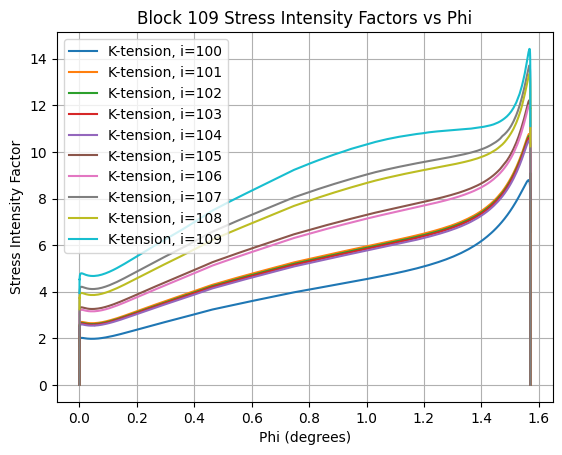

In [5]:

# Plots Ktension vs phi for block i
plt.figure()

for i in range(100, 110):
    plt.plot(block_phi_dataset[i], block_Ktension_dataset[i], label='K-tension, i='+str(i))
    # plt.plot(block_phi_dataset[i], block_Kbending_dataset[i], label='K-bending, i='+str(i))
    # plt.plot(block_phi_dataset[i], block_Kbearing_dataset[i], label='K-bearing, i='+str(i))

plt.xlabel('Phi (degrees)')
plt.ylabel('Stress Intensity Factor')
plt.title(f'Block {i} Stress Intensity Factors vs Phi')
plt.legend()
plt.grid()
plt.show()


## Extracting vertex data

In [ ]:
# Iterate through the data blocks
for i in range(len(block_phi_dataset)):
    # print(f"Analyzing Block {i}")
    max_angle = np.nanmax(block_phi_dataset[i])
    if max_angle > np.radians(91):
        print(max_angle)
    
    # Get all of the phi indices where phi is less than 5% of max phi angle
    phi_threshold = 0.05 * max_angle
    phi_indices = np.where(block_phi_dataset[i] < phi_threshold)[0]

In [9]:
num_no_Ktension_c_vertex = []
num_no_Kbending_c_vertex = []
num_no_Kbearing_c_vertex = []
num_no_Ktension_a_vertex = []
num_no_Kbending_a_vertex = []
num_no_Kbearing_a_vertex = []

Ktension_c_vertex_indices = []
Ktension_c_vertex_values = []
Kbending_c_vertex_indices = []
Kbending_c_vertex_values = []
Kbearing_c_vertex_indices = []
Kbearing_c_vertex_values = []
Ktension_a_vertex_indices = []
Ktension_a_vertex_values = []
Kbending_a_vertex_indices = []
Kbending_a_vertex_values = []
Kbearing_a_vertex_indices = []
Kbearing_a_vertex_values = []

# Iterate through the data blocks
for i in range(len(block_phi_dataset)):
    # print(f"Analyzing Block {i}")
    max_angle = np.nanmax(block_phi_dataset[i])

    # If the max phi is over 90.1 degrees, print the iteration and angle
    if max_angle > np.radians(90.1):
        print(f"Analyzing Block {i}: Max angle exceeded: {max_angle}")
        break

    # ------------ Perform c-vertex extractions -------------
    # Extract the indices where phi is less than c_vertex_phi_threshold degrees (in radians)
    c_vertex_phi_threshold = 0.05 * max_angle
    indices = np.where(block_phi_dataset[i] < c_vertex_phi_threshold)[0]

    # Find the a turn-down point in the Ktension values by comparing discrete slopes
    vertex_value = None
    for j in indices[1:-1]:  # Avoid the first and last index to prevent out-of-bounds access

        # Print the slope of Ktension on index j
        left_slope = block_Ktension_dataset[i][j] - block_Ktension_dataset[i][j-1]
        right_slope = block_Ktension_dataset[i][j+1] - block_Ktension_dataset[i][j]

        if left_slope >= 0 and right_slope < 0:
            vertex_value = block_Ktension_dataset[i][j]
            Ktension_c_vertex_indices.append(j)
            Ktension_c_vertex_values.append(vertex_value)
            break

    if vertex_value is None:
        num_no_Ktension_c_vertex.append(i)
        # Set the value at the last phi index
        vertex_value = block_Ktension_dataset[i][indices[-1]]
        Ktension_c_vertex_indices.append(indices[-1])
        Ktension_c_vertex_values.append(vertex_value)

    # Find the a turn-down point in the Kbending values by comparing discrete slopes
    vertex_value = None
    for j in indices[1:-1]:  # Avoid the first and last index to prevent out-of-bounds access

        # Print the slope of Kbending on index j
        left_slope = block_Kbending_dataset[i][j] - block_Kbending_dataset[i][j-1]
        right_slope = block_Kbending_dataset[i][j+1] - block_Kbending_dataset[i][j]

        if left_slope >= 0 and right_slope < 0:
            vertex_value = block_Kbending_dataset[i][j]
            Kbending_c_vertex_indices.append(j)
            Kbending_c_vertex_values.append(vertex_value)
            break

    if vertex_value is None:
        num_no_Kbending_c_vertex.append(i)
        # Set the value at the last phi index
        vertex_value = block_Kbending_dataset[i][indices[-1]]
        Kbending_c_vertex_indices.append(indices[-1])
        Kbending_c_vertex_values.append(vertex_value)

    # Find the a turn-down point in the Kbearing values by comparing discrete slopes
    vertex_value = None
    for j in indices[1:-1]:  # Avoid the first and last index to prevent out-of-bounds access

        # Print the slope of Kbearing on index j
        left_slope = block_Kbearing_dataset[i][j] - block_Kbearing_dataset[i][j-1]
        right_slope = block_Kbearing_dataset[i][j+1] - block_Kbearing_dataset[i][j]

        if left_slope >= 0 and right_slope < 0:
            vertex_value = block_Kbearing_dataset[i][j]
            Kbearing_c_vertex_indices.append(j)
            Kbearing_c_vertex_values.append(vertex_value)
            break


    if vertex_value is None:
        num_no_Kbearing_c_vertex.append(i)
        # Set the value at the last phi index
        vertex_value = block_Kbearing_dataset[i][indices[-1]]
        Kbearing_c_vertex_indices.append(indices[-1])
        Kbearing_c_vertex_values.append(vertex_value)

    # ---------- Perform a-vertex extractions --------------
    # Extract the indices where phi is within 5% of the max phi angle
    a_vertex_phi_threshold = 0.95 * max_angle
    indices = np.where(block_phi_dataset[i] > a_vertex_phi_threshold)[0]

    # Reverse the search order, starting from the largest phi value
    indices = indices[::-1]

    # Find the a turn-down point in the Ktension values by comparing discrete slopes
    vertex_value = None
    for j in indices[1:-1]:  # Avoid the first and last index to prevent out-of-bounds access

        # Print the slope of Ktension on index j
        left_slope = block_Ktension_dataset[i][j] - block_Ktension_dataset[i][j-1]
        right_slope = block_Ktension_dataset[i][j+1] - block_Ktension_dataset[i][j]

        if left_slope >= 0 and right_slope < 0:
            vertex_value = block_Ktension_dataset[i][j]
            Ktension_a_vertex_indices.append(j)
            Ktension_a_vertex_values.append(vertex_value)
            break

    if vertex_value is None:
        num_no_Ktension_a_vertex.append(i)
        # Set the value at the last phi index
        vertex_value = block_Ktension_dataset[i][indices[-1]]
        Ktension_a_vertex_indices.append(indices[-1])
        Ktension_a_vertex_values.append(vertex_value)

    # Find the a turn-down point in the Kbending values by comparing discrete slopes
    vertex_value = None
    for j in indices[1:-1]:  # Avoid the first and last index to prevent out-of-bounds access

        # Print the slope of Kbending on index j
        left_slope = block_Kbending_dataset[i][j] - block_Kbending_dataset[i][j-1]
        right_slope = block_Kbending_dataset[i][j+1] - block_Kbending_dataset[i][j]

        if left_slope >= 0 and right_slope < 0:
            vertex_value = block_Kbending_dataset[i][j]
            Kbending_a_vertex_indices.append(j)
            Kbending_a_vertex_values.append(vertex_value)
            break
    
    if vertex_value is None:
        num_no_Kbending_a_vertex.append(i)
        # Set the value at the last phi index
        vertex_value = block_Kbending_dataset[i][indices[-1]]
        Kbending_a_vertex_indices.append(indices[-1])
        Kbending_a_vertex_values.append(vertex_value)

    # Find the a turn-down point in the Kbearing values by comparing discrete slopes
    vertex_value = None
    for j in indices[1:-1]:  # Avoid the first and last index to prevent out-of-bounds access

        # Print the slope of Kbearing on index j
        left_slope = block_Kbearing_dataset[i][j] - block_Kbearing_dataset[i][j-1]
        right_slope = block_Kbearing_dataset[i][j+1] - block_Kbearing_dataset[i][j]

        if left_slope >= 0 and right_slope < 0:
            vertex_value = block_Kbearing_dataset[i][j]
            Kbearing_a_vertex_indices.append(j)
            Kbearing_a_vertex_values.append(vertex_value)
            break

    if vertex_value is None:
        num_no_Kbearing_c_vertex.append(i)
        # Set the value at the last phi index
        vertex_value = block_Kbearing_dataset[i][indices[-1]]
        Kbearing_a_vertex_indices.append(indices[-1])
        Kbearing_a_vertex_values.append(vertex_value)
        
print(f"Total blocks with no Ktension c-vertex found: {len(num_no_Ktension_c_vertex)}")
print(f"Total blocks with no Kbending c-vertex found: {len(num_no_Kbending_c_vertex)}")
print(f"Total blocks with no Kbearing c-vertex found: {len(num_no_Kbearing_c_vertex)}")
print(f"Total blocks with no Ktension a-vertex found: {len(num_no_Ktension_a_vertex)}")
print(f"Total blocks with no Kbending a-vertex found: {len(num_no_Kbending_a_vertex)}")
print(f"Total blocks with no Kbearing a-vertex found: {len(num_no_Kbearing_a_vertex)}")

Total blocks with no Ktension c-vertex found: 36413
Total blocks with no Kbending c-vertex found: 3102
Total blocks with no Kbearing c-vertex found: 30154
Total blocks with no Ktension a-vertex found: 0
Total blocks with no Kbending a-vertex found: 105
Total blocks with no Kbearing a-vertex found: 0


In [10]:
print(len(Ktension_c_vertex_values))
print(len(Kbending_c_vertex_values))
print(len(Kbearing_c_vertex_values))
print(len(Ktension_a_vertex_values))
print(len(Kbending_a_vertex_values))
print(len(Kbearing_a_vertex_values))


92149
92149
92149
92149
92149
92149


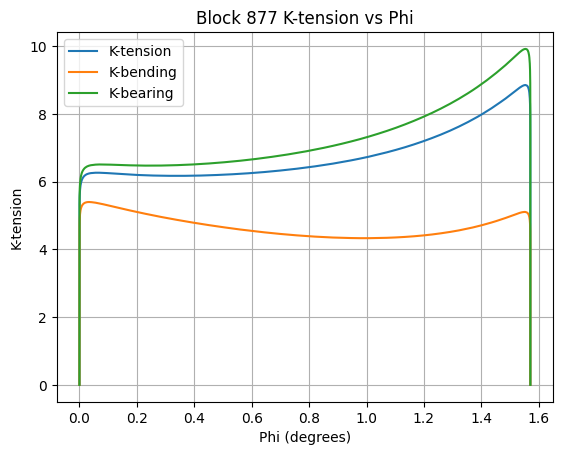

In [12]:
# print(num_no_turndown_idx_blocks)
i = num_no_Ktension_c_vertex[0]

indices = np.where(block_phi_dataset[i] < np.radians(5))[0]
# Search for a local maximum in K-tension within these indices
Ktension_values = block_Ktension_dataset[i][indices]

# Find the a turn-down point in the K-tension values after a postivie slope
turn_down_index = None
num_hits = 0

for j in indices[1:-1]:  # Avoid the first and last index to prevent out-of-bounds access

    # Print the slope of Ktension on index j
    left_slope = Ktension_values[j] - Ktension_values[j-1]
    right_slope = Ktension_values[j+1] - Ktension_values[j]

    # print(left_slope, right_slope, block_phi_dataset[i][j], Ktension_values[j])

    if left_slope >= 0 and right_slope < 0:
        num_hits += 1
        if turn_down_index is None:
            turn_down_index = indices[j]


 # Plot the K-tension values and mark the turn-down point if found
plt.figure()
plt.plot(block_phi_dataset[i], block_Ktension_dataset[i], label='K-tension')
plt.plot(block_phi_dataset[i], block_Kbending_dataset[i], label='K-bending')
plt.plot(block_phi_dataset[i], block_Kbearing_dataset[i], label='K-bearing')


plt.xlabel('Phi (degrees)')
plt.ylabel('K-tension')
plt.title(f'Block {i} K-tension vs Phi')
plt.legend()
plt.grid()
plt.show()

## Turn into ML-ready datasets

### Block parameters are listed as:
- height factor
- thickness
- radius
- W/r
- crack number
- ndom
- a/c
- a/t
- r/t
- b/t
- c

In [27]:
# Define full ML dataset indices for easier readability and slicing
height_factor_idx = 0
thickness_idx = 1
radius_idx = 2
w_over_r_idx = 3
crack_number_idx = 4
ndom_idx = 5
a_over_c_idx = 6
a_over_t_idx = 7
R_over_t_idx = 8
b_over_t_idx = 9
c_idx = 10
Ktension_c_idx = 11
Kbending_c_idx = 12
Kbearing_c_idx = 13
Ktension_a_idx = 14
Kbending_a_idx = 15
Kbearing_a_idx = 16

### Full input param/features, full output K's

In [14]:
num_blocks, num_params = block_params_dataset.shape
num_outputs = 6

all_params_all_Ks = np.ndarray((num_blocks, num_params + num_outputs))

# Iterate through the blocks and insert all parameters, all output Ks
for i in range(num_blocks):
    all_params_all_Ks[i, :num_params] = block_params_dataset[i, :]
    all_params_all_Ks[i, num_params] = Ktension_c_vertex_values[i]
    all_params_all_Ks[i, num_params + 1] = Kbending_c_vertex_values[i]
    all_params_all_Ks[i, num_params + 2] = Kbearing_c_vertex_values[i]
    all_params_all_Ks[i, num_params + 3] = Ktension_a_vertex_values[i]
    all_params_all_Ks[i, num_params + 4] = Kbending_a_vertex_values[i]
    all_params_all_Ks[i, num_params + 5] = Kbearing_a_vertex_values[i]


np.save('all_params_all_Ks.npy', all_params_all_Ks)

### K-tension C-vertex Dataset

In [15]:
# Slice the full dataset to omit unwanted parameters
cols_to_remove = [crack_number_idx, ndom_idx, Kbending_c_idx, Kbearing_c_idx, Ktension_a_idx, Kbending_a_idx, Kbearing_a_idx]
cols_to_keep = [i for i in range(all_params_all_Ks.shape[1]) if i not in cols_to_remove]
major_params_Ktension_c = all_params_all_Ks[:, cols_to_keep]

# print(major_params_Ktension_c.shape)
np.save('major_params_Ktension_c.npy', major_params_Ktension_c)

### All K's, A- and C-vertex Dataset

In [16]:
# Slice the full dataset to omit unwanted parameters
cols_to_remove = [crack_number_idx, ndom_idx]
cols_to_keep = [i for i in range(all_params_all_Ks.shape[1]) if i not in cols_to_remove]
major_params_all_Ks = all_params_all_Ks[:, cols_to_keep]

# print(major_params_Ktension_c.shape)
np.save('major_params_all_Ks.npy', major_params_all_Ks)

### 4 Feature, K-bending C-vertex

In [20]:
# Slice the full dataset to omit unwanted parameters
cols_to_remove = [height_factor_idx, thickness_idx, radius_idx, crack_number_idx, ndom_idx, b_over_t_idx, c_idx, 
                  Ktension_c_idx, Kbearing_c_idx, Ktension_a_idx, Kbending_a_idx, Kbearing_a_idx]
cols_to_keep = [i for i in range(all_params_all_Ks.shape[1]) if i not in cols_to_remove]
four_params_Kbending_c = all_params_all_Ks[:, cols_to_keep]

# print(four_params_Kbending_c.shape)
np.save('four_params_Kbending_c.npy', four_params_Kbending_c)

### 4 feature, K-bearing C-vertex

In [22]:
# Slice the full dataset to omit unwanted parameters
cols_to_remove = [height_factor_idx, thickness_idx, radius_idx, crack_number_idx, ndom_idx, b_over_t_idx, c_idx, 
                  Ktension_c_idx, Kbending_c_idx, Ktension_a_idx, Kbending_a_idx, Kbearing_a_idx]
cols_to_keep = [i for i in range(all_params_all_Ks.shape[1]) if i not in cols_to_remove]
four_params_Kbearing_c = all_params_all_Ks[:, cols_to_keep]

# print(four_params_Kbearing_c.shape)
np.save('four_params_Kbearing_c.npy', four_params_Kbearing_c)

## Plot AFGROW-Style Splines

Unique a/c values: [ 0.1         0.111       0.125       0.1428      0.16670001  0.2
  0.25        0.333       0.5         0.667       0.75        0.80000001
  1.          1.25        1.33299994  1.5         2.          3.
  4.          5.          6.          7.          8.          9.
 10.        ]
Unique a/t values: [0.1        0.2        0.30000001 0.40000001 0.5        0.60000002
 0.69999999 0.80000001 0.89999998 0.94999999]
Unique R/t values: [ 0.1         0.125       0.1428      0.16670001  0.2         0.25
  0.333       0.40000001  0.44440001  0.5         0.57139999  0.667
  0.80000001  1.          1.25        1.5         1.75        2.
  2.25        2.5         3.          4.          5.          6.
  7.          8.         10.        ]
Unique b/t values: [1.]
Unique c values: [1.99999996e-02 2.21999995e-02 2.38000005e-02 ... 8.55855896e+02
 9.00000000e+02 9.50000000e+02]
Data filtered for R/t = 0.10000000149011612: (1520, 17)
[ 0.1         0.111       0.125       0.1428      

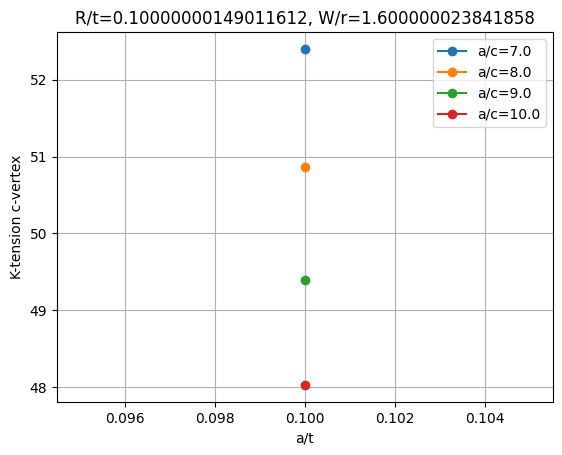

(1520, 17)
  w/r=1.7999999523162842, data points: 8


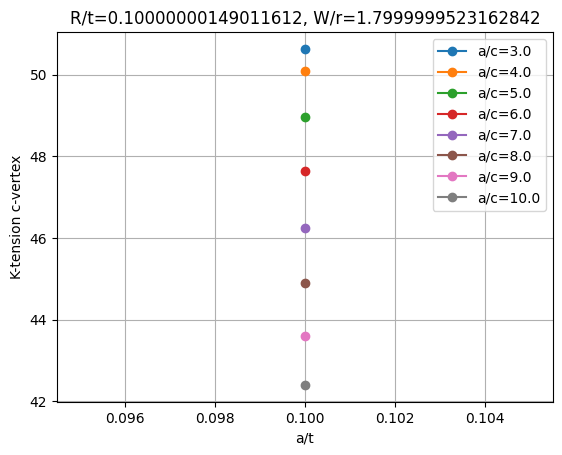

(1520, 17)
  w/r=2.0, data points: 13


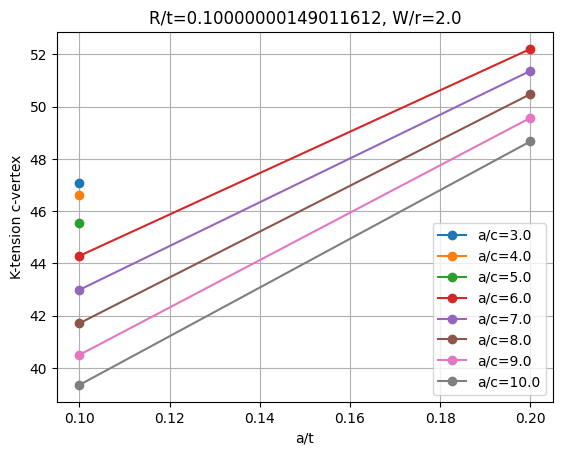

(1520, 17)
  w/r=2.200000047683716, data points: 17


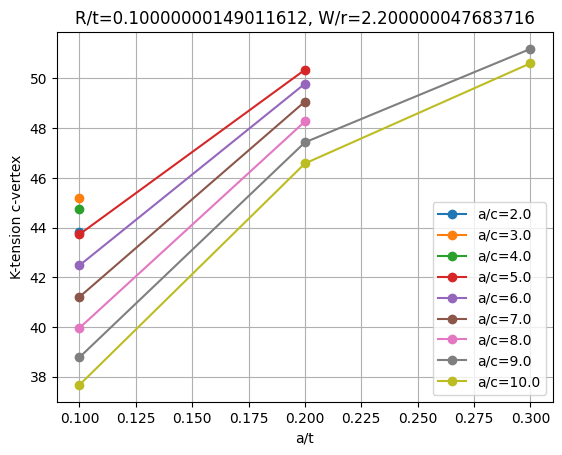

(1520, 17)
  w/r=2.4000000953674316, data points: 21


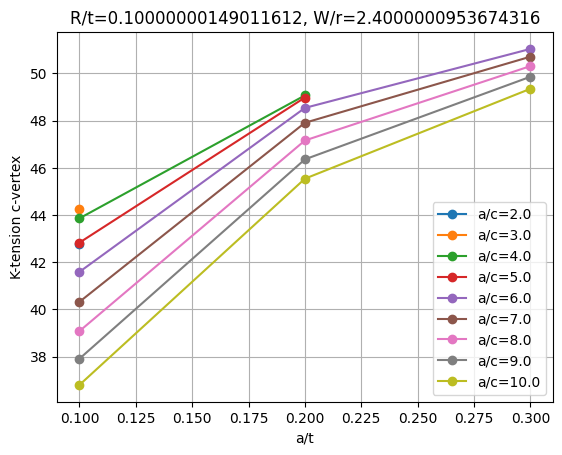

(1520, 17)
  w/r=2.799999952316284, data points: 33


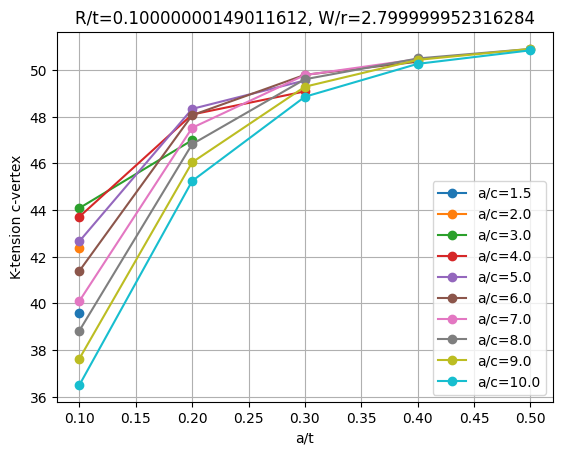

(1520, 17)
  w/r=3.200000047683716, data points: 48


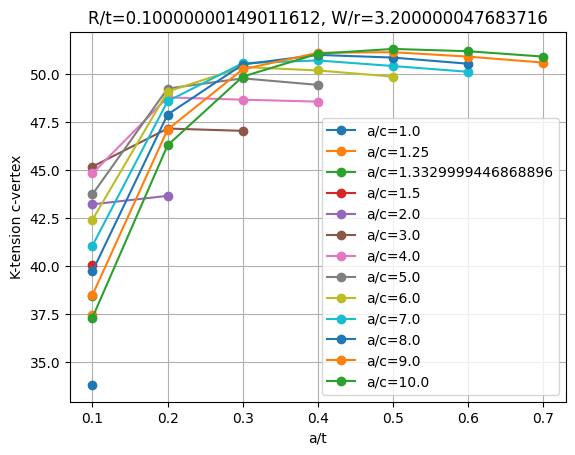

(1520, 17)
  w/r=3.5999999046325684, data points: 62


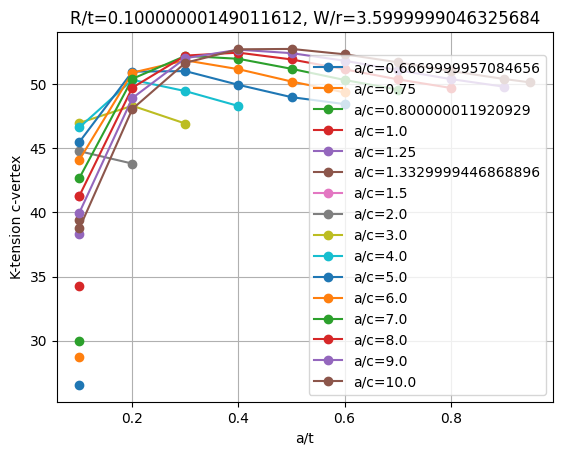

(1520, 17)
  w/r=4.0, data points: 72


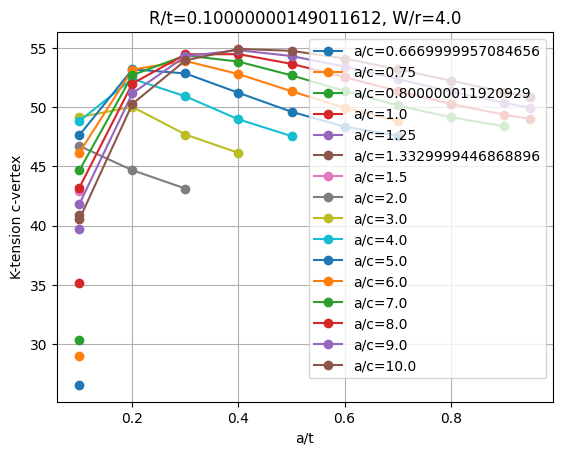

(1520, 17)
  w/r=4.599999904632568, data points: 84


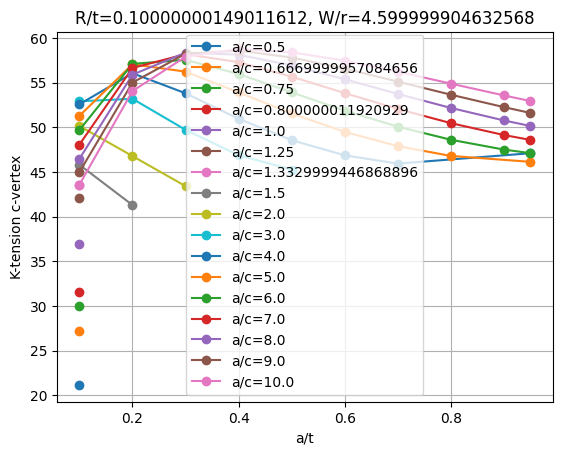

(1520, 17)
  w/r=5.199999809265137, data points: 90


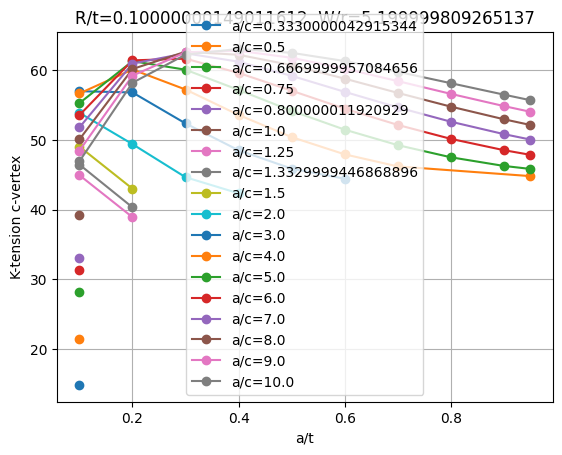

(1520, 17)
  w/r=5.800000190734863, data points: 96


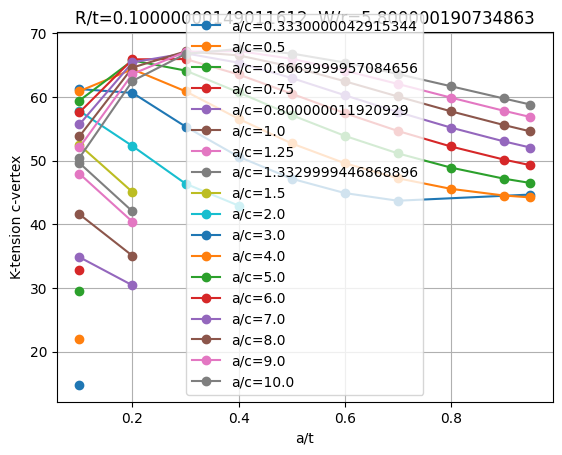

(1520, 17)
  w/r=6.400000095367432, data points: 100


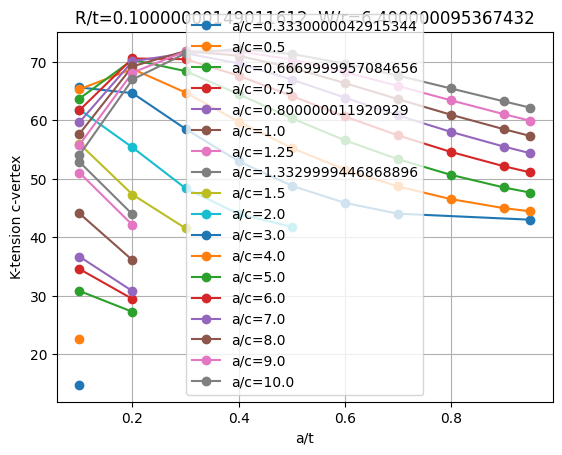

(1520, 17)
  w/r=7.0, data points: 104


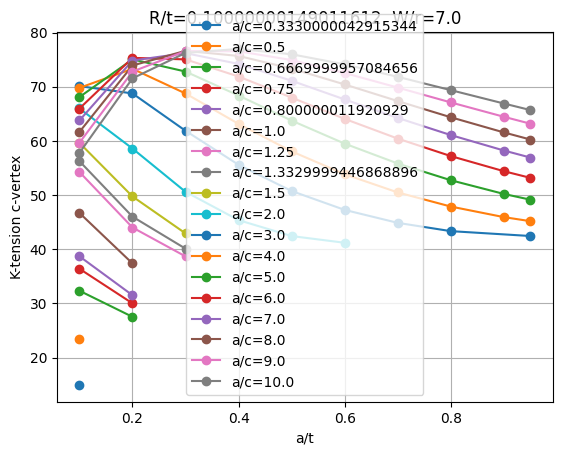

(1520, 17)
  w/r=8.0, data points: 113


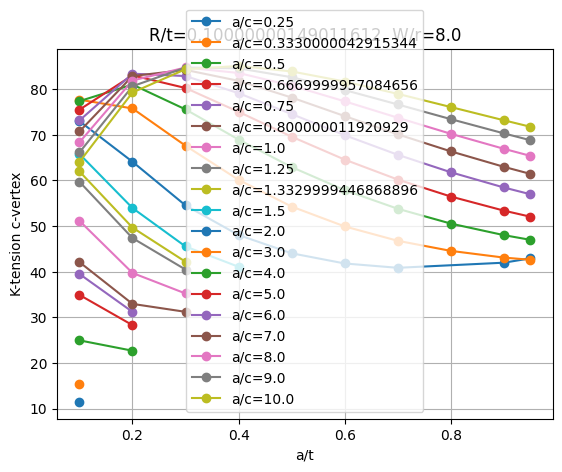

(1520, 17)
  w/r=10.0, data points: 123


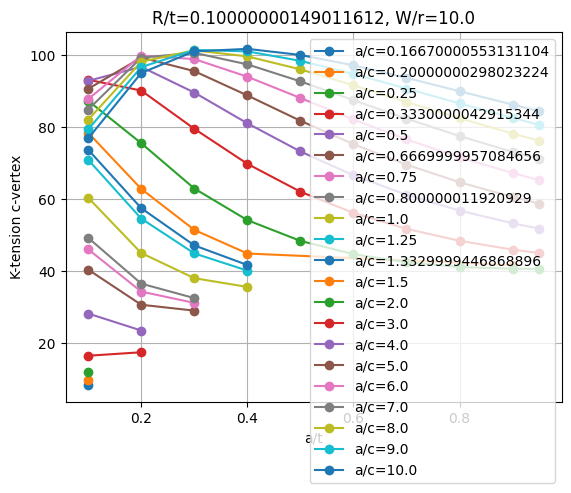

(1520, 17)
  w/r=12.0, data points: 139


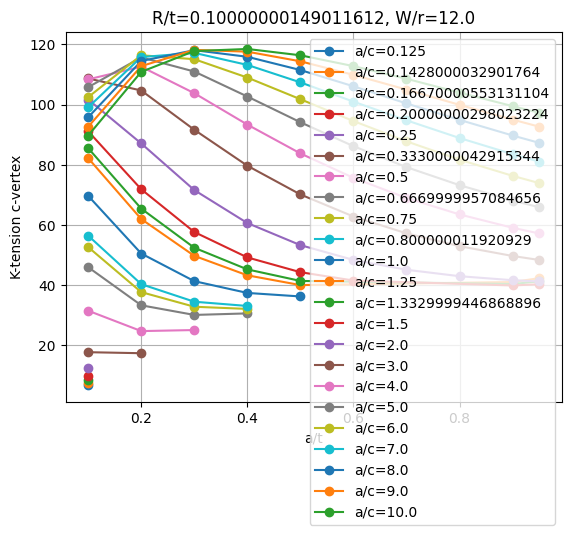

(1520, 17)
  w/r=15.0, data points: 157


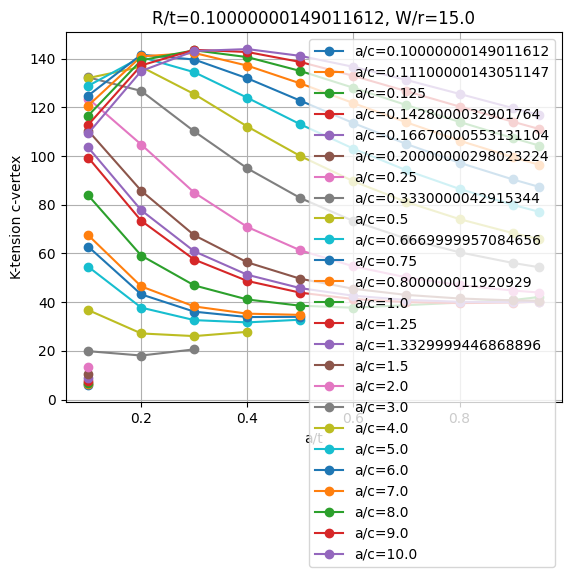

(1520, 17)
  w/r=1000.0, data points: 236


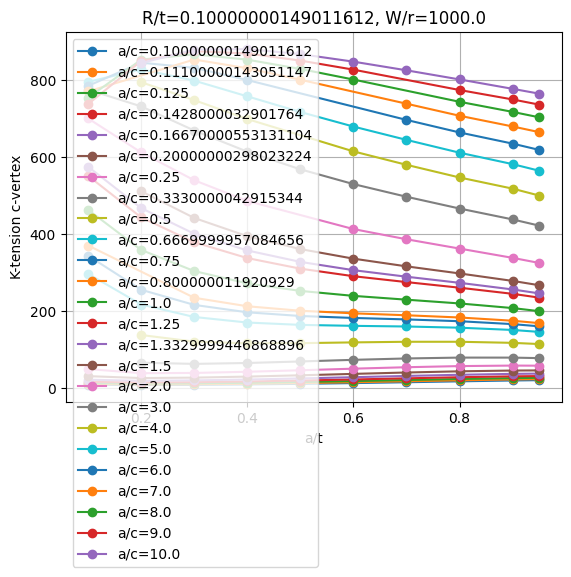

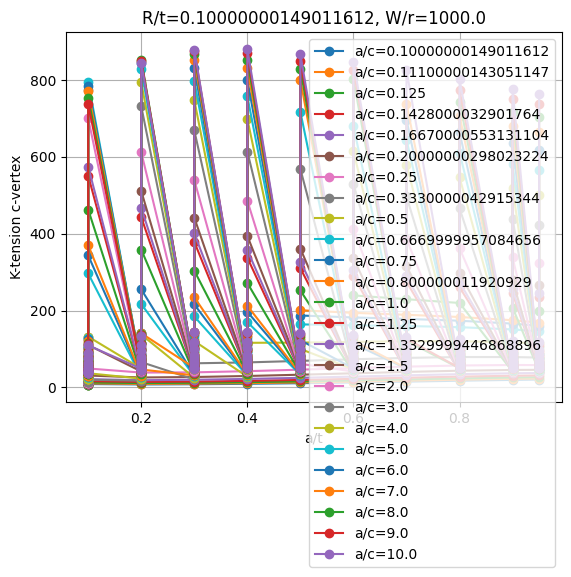

In [28]:
# Load Ktension c data
all_params_all_Ks = np.load('all_params_all_Ks.npy')

# Find all the unique values for each parameter
unique_a_over_c = np.unique(all_params_all_Ks[:, a_over_c_idx])
unique_a_over_t = np.unique(all_params_all_Ks[:, a_over_t_idx])
unique_R_over_t = np.unique(all_params_all_Ks[:, R_over_t_idx])
unique_b_over_t = np.unique(all_params_all_Ks[:, b_over_t_idx])
unique_c = np.unique(all_params_all_Ks[:, c_idx])

print("Unique a/c values:", unique_a_over_c)
print("Unique a/t values:", unique_a_over_t)
print("Unique R/t values:", unique_R_over_t)
print("Unique b/t values:", unique_b_over_t)
print("Unique c values:", unique_c)

# Example: Filter data for specific R/t value
fixed_R_over_t = unique_R_over_t[0]
filtered_data_R_over_t = all_params_all_Ks[all_params_all_Ks[:, R_over_t_idx] == fixed_R_over_t]
print(f"Data filtered for R/t = {fixed_R_over_t}: {filtered_data_R_over_t.shape}")

print(np.unique(filtered_data_R_over_t[:, a_over_c_idx]))
print(np.unique(filtered_data_R_over_t[:, w_over_r_idx]))

# Subfilter data for specific W_over_r value
filtered_unique_w_over_r = np.unique(filtered_data_R_over_t[:, w_over_r_idx])

for w_over_r in filtered_unique_w_over_r:
    print(filtered_data_R_over_t.shape)
    filtered_w_over_r_data = filtered_data_R_over_t[filtered_data_R_over_t[:, w_over_r_idx] == w_over_r]
    print(f"  w/r={w_over_r}, data points: {filtered_w_over_r_data.shape[0]}")

    # Plot Ktension_c vs a/t for different a/c ratios, with fixd W/r
    plt.figure()
    # for a_over_c in np.concatenate((unique_a_over_c[:3], unique_a_over_c[-3:])):  # Ensure 10 is included if not already present
    for a_over_c in unique_a_over_c[:]:
        subset = filtered_w_over_r_data[filtered_w_over_r_data[:, a_over_c_idx] == a_over_c]
        if subset.size > 0:
            # Plot a separate line for each a/c value
            plt.plot(subset[:, a_over_t_idx], subset[:, Kbearing_c_idx], marker='o', label=f'a/c={a_over_c}')

        # print(f"a/c={a_over_c}, data points: {subset.shape[0]}")
        # if a_over_c == 10:
            # print(f"Unique height factors: {np.unique(subset[:, height_factor_idx])}")
            # print(f"Unique thickness factors: {np.unique(subset[:, thickness_idx])}")
            # print(f"Unique radius factors: {np.unique(subset[:, radius_idx])}")
            # print(f"Unique w/r factors: {np.unique(subset[:, w_over_r_idx])}")
            # print(f"Unique a/c factors: {np.unique(subset[:, a_over_c_idx])}")
            # print(f"Unique a/t factors: {np.unique(subset[:, a_over_t_idx])}")
            # print(f"Unique R/t factors: {np.unique(subset[:, R_over_t_idx])}")
            # print(f"Unique b/t factors: {np.unique(subset[:, b_over_t_idx])}")
            # print(f"Unique c factors: {np.unique(subset[:, c_idx])}")
            # print(subset)
            # print(np.concatenate((subset[:, a_over_t_idx].reshape(-1, 1), subset[:, -1].reshape(-1, 1)), axis=1))

    plt.xlabel('a/t')
    plt.ylabel('K-tension c-vertex')
    plt.legend()
    plt.title(f'R/t={fixed_R_over_t}, W/r={w_over_r}')
    plt.grid()
    plt.show()

# Aggregate plots without filtering w/r
plt.figure()
for a_over_c in unique_a_over_c[:]:
    subset = filtered_data_R_over_t[filtered_data_R_over_t[:, a_over_c_idx] == a_over_c]
    if subset.size > 0:
        # Plot a separate line for each a/c value
        plt.plot(subset[:, a_over_t_idx], subset[:, Kbearing_c_idx], marker='o', label=f'a/c={a_over_c}')

    # print(f"a/c={a_over_c}, data points: {subset.shape[0]}")
    # if a_over_c == 10:
        # print(f"Unique height factors: {np.unique(subset[:, height_factor_idx])}")
        # print(f"Unique thickness factors: {np.unique(subset[:, thickness_idx])}")
        # print(f"Unique radius factors: {np.unique(subset[:, radius_idx])}")
        # print(f"Unique w/r factors: {np.unique(subset[:, w_over_r_idx])}")
        # print(f"Unique a/c factors: {np.unique(subset[:, a_over_c_idx])}")
        # print(f"Unique a/t factors: {np.unique(subset[:, a_over_t_idx])}")
        # print(f"Unique R/t factors: {np.unique(subset[:, R_over_t_idx])}")
        # print(f"Unique b/t factors: {np.unique(subset[:, b_over_t_idx])}")
        # print(f"Unique c factors: {np.unique(subset[:, c_idx])}")
        # print(subset)
        # print(np.concatenate((subset[:, a_over_t_idx].reshape(-1, 1), subset[:, -1].reshape(-1, 1)), axis=1))

plt.xlabel('a/t')
plt.ylabel('K-tension c-vertex')
plt.legend()
plt.title(f'R/t={fixed_R_over_t}, W/r={w_over_r}')
plt.grid()
plt.show()